In [1]:
import pennylane as qml
from pennylane import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from random import random
import time

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm

import scipy
from scipy import optimize

In [3]:
#declare devices for backend

shots = 100

dev_default = qml.device('default.qubit', wires=2)
dev_numpy = qml.device('forest.numpy_wavefunction', wires=2)
dev_simulator = qml.device('forest.wavefunction', wires=2)
dev_pyqvm = qml.device('forest.qvm', device='2q-pyqvm', shots=shots)
dev_qvm = qml.device('forest.qvm', device='Aspen-4-2Q-A', shots=shots)

In [24]:
#define Learning-2-Learn class with LSTM architecture

class L2L(nn.Module):
    
    def __init__(self, circ_function):
        super().__init__()
        self.num_feats = 3  # rnn_output, qnn input params
        self.batch_size = 16
        self.rnn_input_size = 1 # qnn output size
        
        self.hid_cell = None
        self.rnn_output = None
        self.qnn_output = None
        
        self.lstm = nn.LSTM(
            input_size=self.rnn_input_size, hidden_size=self.num_feats, num_layers=1, dropout=0
        )
        
        self.function = circ_function
        
        self.target = None

    def init_hid_cell(self, seq_len=1):
        self.rnn_output = torch.tensor([])
        self.qnn_output = torch.zeros(seq_len, self.batch_size, self.rnn_input_size)
        
        hidden = torch.zeros(seq_len, self.batch_size, self.num_feats)
        cell = torch.zeros(seq_len, self.batch_size, self.num_feats)
        self.hid_cell = (hidden, cell)

    def init_target(self):
        #initialize random target expectation value value between 0 and 1
        self.target = (torch.rand(self.batch_size, self.rnn_input_size)-0.5)*2

    def step(self):
        assert self.hid_cell is not None
    
        x = self.qnn_output[[-1], :, :]
        # display(f'RNN input {x.shape}')
        
        rnn_output, self.hid_cell = self.lstm(x, self.hid_cell)
        self.rnn_output = torch.cat((self.rnn_output, rnn_output), dim=0) #(seq_dim, batch_size, feature_size)
        # display(f'RNN output: {rnn_output.shape} RNN hist {self.rnn_output.shape}')
        
        assert rnn_output.shape[0] == 1
        qnn_output = torch.zeros_like(x)
        # this turns into proper batch handling
        for i in range(rnn_output.shape[1]):
            qnn_input_batch_element = rnn_output[0, i, :]
            qnn_output_batch_element = self.function(qnn_input_batch_element)
            qnn_output[0, i, :] = qnn_output_batch_element
        
        #subtract target value so that loss is simply minimized at 0
        qnn_output[0,:,:] = qnn_output[0,:,:] - self.target
        # display(f'circuit output: {qnn_output.shape}')
        self.qnn_output = torch.cat((self.qnn_output, qnn_output), dim=0)

        return self.qnn_output

    def loss(self, true=None):
        # display(f'true: {true.shape}, pred: {self.qnn_output.shape}')
        
        if true==None:
            true = torch.zeros(self.qnn_output.shape)
            
        assert true.shape == self.qnn_output.shape
        
        return F.mse_loss(self.qnn_output, true)

    def numpy_output(self):
        return self.qnn_output.detach().numpy().squeeze()

def circ_function(dev):
    
    @qml.qnode(dev, interface='torch')
    def circuit(parameters):
        phi = 2*np.pi*parameters[:2]
        theta = 2*np.pi*parameters[-1]
        qml.RX(phi[0], wires=0)
        qml.RZ(phi[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RX(theta, wires=0)
        return qml.expval(qml.PauliZ(0))

    return circuit

100%|██████████| 100/100 [02:48<00:00,  1.69s/it]

CPU times: user 3min 47s, sys: 1min 57s, total: 5min 45s
Wall time: 2min 48s


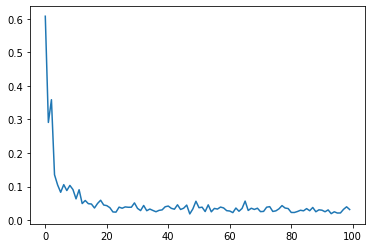

In [25]:
%%time 

l2l = L2L(circ_function(dev_default))

optimizer = optim.Adam(l2l.parameters(), lr=0.1)

num_epoch = 100
num_steps = 10

all_loss = []
for epoch_ind in tqdm(range(num_epoch)):

    l2l.zero_grad()
    l2l.init_hid_cell()
    l2l.init_target()

    for i in range(num_steps):
        l2l.step()

    loss = l2l.loss()
    loss.backward()
    optimizer.step()

    all_loss.append(loss.item())

plt.plot(all_loss)

In [12]:
#define class to call the different optimizers on a device

# neural optimizer
def neural_optimizer(target):
    l2l.batch_size = 1

    l2l.init_hid_cell()
    l2l.target = torch.tensor([[target]])

    for i in range(num_steps):
        l2l.step()

    return l2l.qnn_output[1:].view(-1).detach().numpy()

# gradient descent
def gradient_descent(target, dev, lr=0.1):
    circuit = circ_function(dev)

    def cost(parameters):
        result = circuit(parameters)
        return torch.abs(result - target)**2, result

    parameters = Variable(torch.rand(3), requires_grad=True)

    opt = torch.optim.Adam([parameters], lr = lr)

    def closure():
        opt.zero_grad()
        loss, result = cost(parameters)
        loss.backward()
        return loss, result

    output = []

    for i in range(num_steps):
        loss, result = opt.step(closure)
        output.append(result-target)

    return output

def neldermead(target, dev):

    circuit = circ_function(dev)
    
    def cost(parameters):
        result = circuit(parameters)
        return torch.abs(result - target)**2
    
    output = []
    def callback(x):
        fobj = circuit(x)
        output.append(fobj)
    
    initial_par = np.random.rand(3)
    opt_parameters = scipy.optimize.minimize(cost, initial_par, method='Nelder-Mead', callback=callback,
                                             options={'maxfev': num_steps, 'return_all': False})
    
    return output

In [56]:
def eval_plots(l2l, dev, target):
    l2l.function = circ_function(dev)

    fig, ax = plt.subplots(figsize = (12,7))
    start = time.time()
    ax.plot(neural_optimizer(target))
    stop = time.time()
    print('Neural optimizer took %.4f seconds.' %(stop-start))

    start = time.time()
    ax.plot(gradient_descent(target, dev))
    stop = time.time()
    print('Gradient descent took %.4f seconds.' %(stop-start))

    start = time.time()
    nelder_mead = neldermead(target, dev)
    ax.plot(np.array(nelder_mead)-target)
    stop = time.time()
    print('Nelder-Mead took %.4f seconds.' %(stop-start))

    ax.legend(['neural optimizer', 'gradient descent', 'nelder_mead'])
    _, _ = plt.xlabel('steps'), plt.ylabel('error')
    _ = ax.set_title('2 qubit rotation (device: %s)' %dev.short_name)

Neural optimizer took 0.0274 seconds.
Gradient descent took 0.1185 seconds.
Nelder-Mead took 0.0274 seconds.


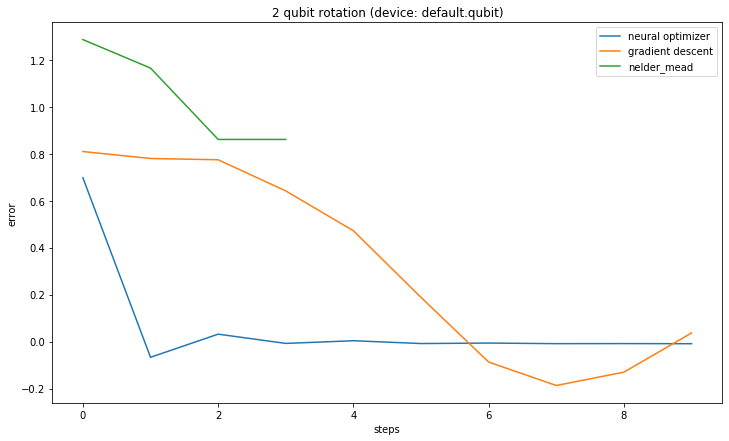

In [58]:
#set a target for the expectation value and evaluate on the default.qubit backend
target = -0.7
dev = dev_default

eval_plots(l2l, dev, target)

Neural optimizer took 0.4849 seconds.
Gradient descent took 2.4584 seconds.
Nelder-Mead took 0.5293 seconds.


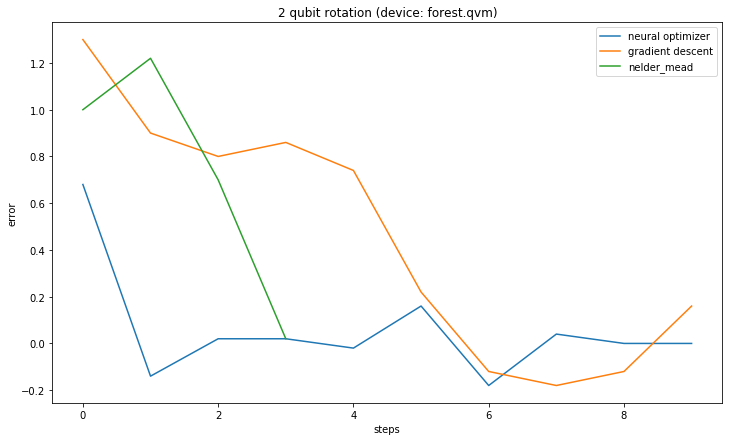

In [73]:
dev_default = qml.device('default.qubit', wires=2)
dev_numpy = qml.device('forest.numpy_wavefunction', wires=2)
dev_simulator = qml.device('forest.wavefunction', wires=2)

dev_pyqvm = qml.device('forest.qvm', device='2q-pyqvm', shots=shots)
dev_qvm = qml.device('forest.qvm', device='Aspen-4-2Q-A', shots=shots)
# dev_qpu = qml.device('forest.qpu', device='Aspen-4-2Q-A', shots=shots)

#set a target for the expectation value and evaluate on backend of your choice
target = -0.7
dev = dev_qvm

eval_plots(l2l, dev, target)